In [1]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle
import re
from datetime import datetime
import shutil

from scipy.io import loadmat
import tkinter as tk
from tkinter import filedialog

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)

/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SpikeInterface version: 0.103.2


In [2]:
def extract_datetime(path):
    m = re.search(r'(\d{6}_\d{6})', path)
    if m:
        return datetime.strptime(m.group(1), "%y%m%d_%H%M%S")
    return datetime.min 

In [3]:
basepath = "/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03"
dataPath = glob.glob(basepath+'/*/amplifier.dat')
dataPath = sorted(dataPath, key=extract_datetime)
display(dataPath)
chanMapPath = glob.glob(basepath+'/chanMap.mat')[0]

['/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat',
 '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat',
 '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat',
 '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat',
 '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat',
 '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat']

## Mapping channel

[]


(<matplotlib.collections.PolyCollection at 0x7f9882688590>, None)

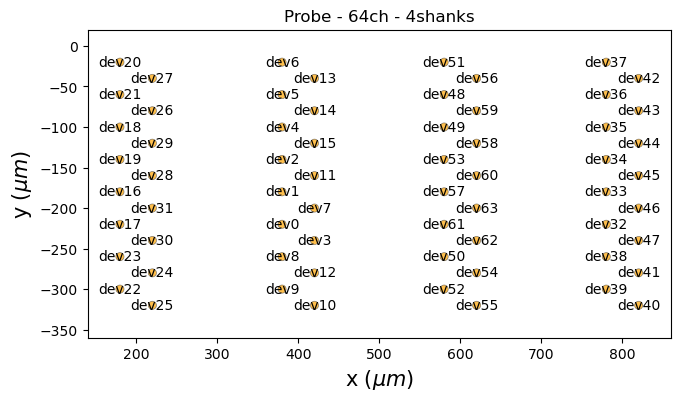

In [4]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1
bad_ch_ids = np.where(chanMapmat['connected'][:,0]==0)[0]
print(bad_ch_ids)

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(8,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

## Concatenate .dat

In [ ]:
fs = 20000
num_channels = len(probe.device_channel_indices)
recording_list =[]
for i in range(len(dataPath)):
    recording_ = se.read_binary(dataPath[i], sampling_frequency=fs, dtype='int16', num_channels=num_channels, gain_to_uV =0.195, offset_to_uV=0)
    # recording_ = se.read_binary(dataPath[i], sampling_frequency=fs, dtype='int16', num_channels=64)
    print(dataPath[i])
    recording_list.append(recording_)
recording = si.concatenate_recordings(recording_list)

# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(basepath) / file_name

# Write binary recording directly with desired filename
si.write_binary_recording(recording, file_paths=str(final_dat_path), add_file_extension=False, over_write=True ,verbose=True, **job_kwargs)
print(f"Saved to: {final_dat_path}")

/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat
/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat
/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat
/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat
/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat
/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat


## Preprocessing
### Set probe
### Remove bad channel
### Bandpass filter (500 - 8000 Hz)
### Common median filter 

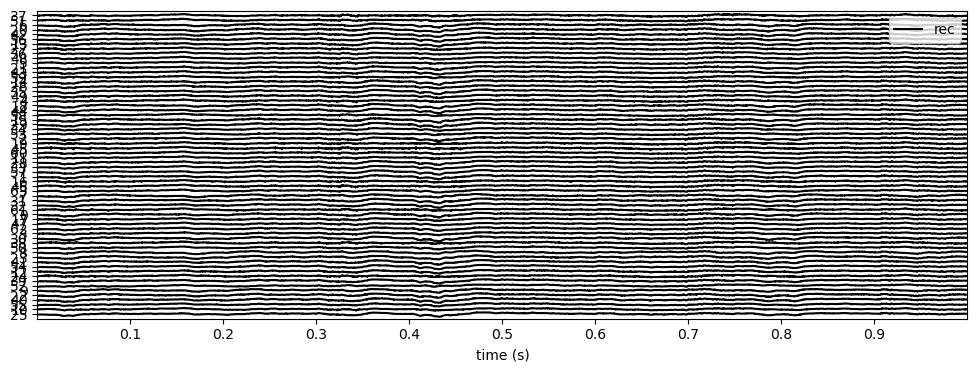

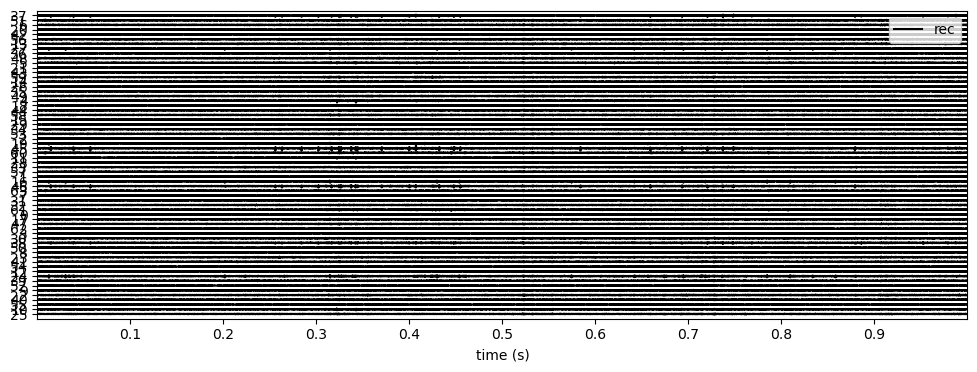

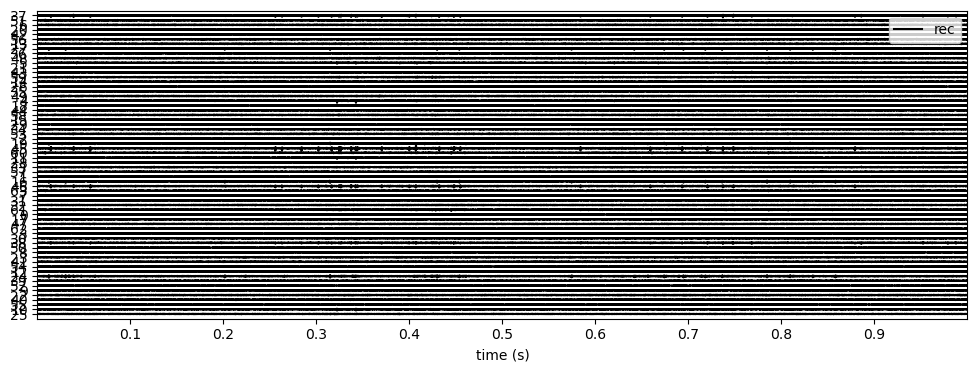

In [ ]:
recording = recording.set_probe(probe, group_mode='by_shank')
recording = recording.remove_channels(remove_channel_ids=bad_ch_ids)

tmin = 0
twind = 1
segment_index=0

sw.plot_traces(recording, channel_ids=recording.get_channel_ids() , order_channel_by_depth=True, show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 4))
recording_f = spre.bandpass_filter(recording, freq_min=500, freq_max=8000)
sw.plot_traces(recording_f, channel_ids=recording_f.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 4))
recording_cmr = spre.common_reference(recording_f, reference='local', local_radius=[50,200] , operator='median')
sw.plot_traces(recording_cmr, channel_ids=recording_cmr.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 4))

## Spike Sorting

In [18]:
params = ss.get_default_sorter_params('kilosort4')
params

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'batch_downsampling': 1,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_neighbors': 10,
 'cluster_downsampling': 1,
 'max_cluster_subset': 25000,
 'x_centers': None,
 'cluster_init_seed': 5,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correctio

In [19]:
params = ss.get_default_sorter_params('kilosort4')
# params['fs'] = fs
params['nt'] = 41
params['nblocks'] = 0
params['batch_size'] = 120000
params['Th_single_ch'] = 4
params['Th_universal'] = 8
params['Th_learned'] = 8
params['max_peels'] = 150
params['nearest_templates'] = 150
params['n_templates'] = 10
params['dmin'] = 20
params['dminx'] = 40
params['nearest_chans'] = 12
params['max_channel_distance'] = 120
params['x_centers'] = 8
params['whitening_range'] = 24
params['highpass_cutoff'] = 500
params['do_CAR'] = False
params['acg_threshold'] = 0.5
params['ccg_threshold'] = 0.0
params['n_jobs'] = n_jobs
params['delete_recording_dat'] = False
params['clear_cache'] = True

In [20]:
%%time
sorting = ss.run_sorter(
    sorter_name="kilosort4",
    recording=recording,
    folder=basepath + '/kilosort4',
    remove_existing_folder=True,
    with_output=True,
    **params
)

100%|██████████| 7/7 [05:00<00:00, 42.93s/it]

100%|██████████| 2022/2022 [01:57<00:00, 17.23it/s]

100%|██████████| 7/7 [08:21<00:00, 71.63s/it] 



CPU times: user 28min 20s, sys: 38.3 s, total: 28min 58s
Wall time: 29min 10s


## Postprocessing
### Remove duplicated spikes from same cluster
### Remove redundant clusters

In [32]:
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)
sa_tmp = si.create_sorting_analyzer(sorting_removed_duplicates, recording_cmr, format="memory", sparse=False)
sa_tmp.compute("random_spikes")
sa_tmp.compute("waveforms")
sa_tmp.compute("templates")
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=True, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes", 
    extra_outputs=True
)
print(f"Removed {len(redundancy_info)} redundant units.")

# for i in range(len(redundancy_info)):
#     sw.plot_crosscorrelograms(
#         sorting_analyzer_or_sorting=sorting_removed_duplicates,
#         unit_ids=redundancy_info[i],
#         bin_ms=1,
#         window_ms=25.0,
#         figsize=(4, 3)
#     )


compute_waveforms (no parallelization): 100%|██████████| 12129/12129 [28:42<00:00,  7.04it/s]



Removed 384 redundant units.


### Calculare unit features

In [33]:
phydir2 = basepath + "/kilosort4_postprocess"
analyzer_folder = Path(phydir2 + "/analyzer_cache") 

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    analyzer.compute(
        {
            "random_spikes": {},
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},

            "principal_components": {"n_components": 7, "mode": "by_channel_local"},

            "template_metrics": {},       
            "template_similarity": {},    

            "correlograms": {},

            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)


compute_waveforms (workers: 506 processes): 100%|██████████| 6065/6065 [00:13<00:00, 441.41it/s]

noise_level (workers: 20 processes): 100%|██████████| 20/20 [00:00<00:00, 113.76it/s]

Projecting waveforms: 100%|██████████| 308/308 [00:00<00:00, 621.68it/s]
Compute : spike_amplitudes + spike_locations (workers: 506 processes): 100%|██████████| 6065/6065 [00:14<00:00, 421.86it/s]



### Merge clusters

In [34]:
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 1 groups to merge.
Found 1 groups to merge.


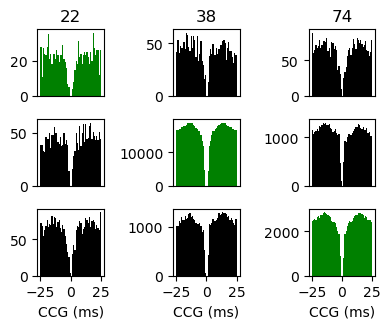

In [35]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [36]:
mergeable = analyzer.are_units_mergeable(merge_unit_groups=merge_groups, merging_mode="soft", sparsity_overlap=0.5)
merge_groups   = [g for g, ok in mergeable.items() if ok]
nonmerge_groups  = [g for g, ok in mergeable.items() if not ok]
analyzer_merged_folder = Path(phydir2 + "/analyzer_cache_merged")
if analyzer_merged_folder.exists():
    try:
        shutil.rmtree(analyzer_merged_folder)
    except:
        pass
analyzer_merged = analyzer.merge_units(
    merge_unit_groups=merge_groups,
    merging_mode='soft', 
    censor_ms=0.5, 
    sparsity_overlap=0.5,
    return_new_unit_ids=False, 
    format="binary_folder", 
    folder=analyzer_merged_folder,
    overwrite=True,       
    **job_kwargs     
)

### Calcurate quality metrics and export for manual curation

In [37]:
qm_params = sqm.get_default_qm_params()  
metrics_df = sqm.compute_quality_metrics(
    analyzer_merged,
    metric_names=['isi_violation','presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,   # PCs are computed above
    n_jobs=n_jobs, progress_bar=True
)

In [38]:
export_to_phy(
    sorting_analyzer=analyzer_merged,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# --- Fix params.py for Phy ---
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Fix dat_path
dat_relative_path = '/local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/kilosort4/sorter_output/recording.dat'
content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")

# 2. Fix hp_filtered 
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"
    
# Write back
with open(params_file, 'w') as f:
    f.write(content)
print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path}")

extract PCs (workers: 506 processes): 100%|██████████| 6065/6065 [00:17<00:00, 339.35it/s]



Run:
phy template-gui  /local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/kilosort4_postprocess/params.py
Fixed dat_path in /local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/kilosort4_postprocess/params.py
Set dat_path to: /local/workdir/ys2375/SpikeSortingPipeline/data/whiskey_day03/kilosort4/sorter_output/recording.dat


In [39]:
def mark_noise_clusters_from_metrics(
    phy_dir: str | Path,
    metrics_df: pd.DataFrame,
    thresholds: dict,
    backup: bool = True,
    reset_to_unsorted: bool = True,
) -> pd.DataFrame:
    """
    Update Phy's `cluster_group.tsv` to mark `group = "noise"` based on quality metrics.

    Parameters
    ----------
    phy_dir : str | Path
        Phy output folder containing `cluster_group.tsv` and `cluster_si_unit_ids.tsv`.
    metrics_df : pd.DataFrame
        DataFrame indexed by SI unit_id (or with a 'cluster_id'/'si_unit_id' column) that contains:
        - isi_violations_ratio
        - isi_violations_count
        - presence_ratio
        - snr
        - amplitude_median
    thresholds : dict
        Rules to mark noise. Supported keys (use any subset):
        - "isi_violations_ratio_gt": float  # mark noise if ratio > value
        - "isi_violations_count_gt": int    # mark noise if count > value
        - "presence_ratio_lt": float        # mark noise if presence < value
        - "snr_lt": float                   # mark noise if snr < value
        - "amplitude_median_lt": float    # mark noise if abs(amplitude_median) < value
    backup : bool
        If True, make a timestamped backup of the original TSV before overwriting.
    reset_to_unsorted : bool
        If True, reset all existing labels to "unsorted" before applying new noise labels.

    Returns
    -------
    pd.DataFrame
        The updated `cluster_group.tsv` contents as a DataFrame sorted by cluster_id.
    """
    phy_dir = Path(phy_dir)

    # --- 1) Map cluster_id (Phy) <-> si_unit_id (SpikeInterface)
    map_path = phy_dir / "cluster_si_unit_ids.tsv"
    if not map_path.exists():
        raise FileNotFoundError(f"Mapping not found: {map_path}")
    mapping = pd.read_csv(map_path, sep="\t")  # columns: cluster_id, si_unit_id
    mapping["cluster_id"] = pd.to_numeric(mapping["cluster_id"], errors="coerce").astype("Int64")
    mapping["si_unit_id"] = pd.to_numeric(mapping["si_unit_id"], errors="coerce")

    # --- 2) Normalize metrics_df to have a 'si_unit_id' column, then join mapping to get cluster_id
    df = metrics_df.copy()
    if "si_unit_id" not in df.columns and "cluster_id" not in df.columns:
        # assume index is SI unit_id
        df.index.name = "si_unit_id"
        df = df.reset_index()
    if "cluster_id" in df.columns and "si_unit_id" not in df.columns:
        # rare case: metrics already in cluster_id space
        df = df.merge(mapping, on="cluster_id", how="inner")
    else:
        df = df.merge(mapping, on="si_unit_id", how="inner")
    df["cluster_id"] = pd.to_numeric(df["cluster_id"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["cluster_id"]).set_index("cluster_id").sort_index()

    # --- 3) Build boolean masks for each rule (missing columns are treated as NaN -> False)
    # Normalize amplitude to absolute if requested
    df["_amp_abs_"] = np.abs(df["amplitude_median"]) if "amplitude_median" in df.columns else np.nan

    conds = []
    # ISI violations: both ratio AND count must exceed thresholds (AND condition)
    if ("isi_violations_ratio_gt" in thresholds and "isi_violations_count_gt" in thresholds and
        "isi_violations_ratio" in df.columns and "isi_violations_count" in df.columns):
        isi_cond = ((df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"]) &
                   (df["isi_violations_count"] > thresholds["isi_violations_count_gt"]))
        conds.append(isi_cond)
    elif "isi_violations_ratio_gt" in thresholds and "isi_violations_ratio" in df.columns:
        conds.append(df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"])
    elif "isi_violations_count_gt" in thresholds and "isi_violations_count" in df.columns:
        conds.append(df["isi_violations_count"] > thresholds["isi_violations_count_gt"])
    
    if "presence_ratio_lt" in thresholds and "presence_ratio" in df.columns:
        conds.append(df["presence_ratio"] < thresholds["presence_ratio_lt"])
    if "snr_lt" in thresholds and "snr" in df.columns:
        conds.append(df["snr"] < thresholds["snr_lt"])
    if "amplitude_median_lt" in thresholds and "_amp_abs_" in df.columns:
        conds.append(df["_amp_abs_"] < thresholds["amplitude_median_lt"])

    noise_mask = pd.concat(conds, axis=1).any(axis=1) if conds else pd.Series(False, index=df.index)

    # --- 4) Read or create cluster_group.tsv (Phy expects: cluster_id<TAB>group)
    cg_path = phy_dir / "cluster_group.tsv"
    if cg_path.exists():
        cg = pd.read_csv(cg_path, sep="\t")
        if not {"cluster_id", "group"}.issubset(set(cg.columns)):
            raise ValueError("cluster_group.tsv must have columns: 'cluster_id', 'group'")
    else:
        # initialize as 'unsorted' for all clusters listed in mapping
        cg = pd.DataFrame({"cluster_id": mapping["cluster_id"], "group": "unsorted"})

    cg["cluster_id"] = pd.to_numeric(cg["cluster_id"], errors="coerce").astype("Int64")
    cg = cg.set_index("cluster_id")

    # --- 5) Reset all to unsorted if requested, then apply noise labels
    if reset_to_unsorted:
        cg["group"] = "unsorted"
    else:
        cg.loc[df.index, "group"] = cg.loc[df.index, "group"].fillna("unsorted")
    
    cg.loc[noise_mask.index[noise_mask], "group"] = "noise"

    # --- 6) Save (with backup)
    out_df = cg.reset_index().sort_values("cluster_id")
    if backup and cg_path.exists():
        bak = cg_path.with_suffix(".bak.tsv")
        shutil.copyfile(cg_path, bak)
    out_df.to_csv(cg_path, sep="\t", index=False)

    return out_df

In [40]:
th = dict(
    isi_violations_ratio_gt = 3, isi_violations_count_gt = 50,  # mark as noise if ratio and violations count is too high
    presence_ratio_lt       = 0.1,   # OR presence < 0.2
    snr_lt                  = 0.3,   # OR snr < 0.3
    amplitude_median_lt = 25.0,  # OR absolute amplitude < 25 µV
)
updated  = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 161
